# Tensorflow Speech Commands Recognition

### Colab Free Tier Nvidia GPU Used for Training

In [1]:
!nvidia-smi

Mon Aug 22 07:32:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Collection
- __Data Source:__ https://www.kaggle.com/competitions/tensorflow-speech-recognition-challenge

<img src="https://cdn.hackernoon.com/images/VQee2H7b9MdqlHMpVjYYgK9YsSu2-3fe355r.jpeg">

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!chmod 600 /content/kaggle.json
!kaggle competitions download -c tensorflow-speech-recognition-challenge
!unzip *.zip
!7za x train.7z

100% 3.50G/3.50G [00:26<00:00, 200MB/s]
100% 3.50G/3.50G [00:26<00:00, 144MB/s]
Archive:  tensorflow-speech-recognition-challenge.zip
  inflating: link_to_gcp_credits_form.txt  
  inflating: sample_submission.7z    
  inflating: test.7z                 
  inflating: train.7z                

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                          

In [3]:
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, silhouette_score
import IPython.display as ipd
import plotly.express as px
import plotly.graph_objs as go
from sklearn.impute import KNNImputer
from tqdm import tqdm
import warnings
import scipy.cluster.hierarchy as shc
from plotly.offline import init_notebook_mode

tqdm.pandas()
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
init_notebook_mode(connected=True)

# What is Speech Recognition ?
- Speech recognition is an interdisciplinary subfield of computer science and computational linguistics that develops methodologies and technologies that enable the recognition and translation of spoken language into text by computers with the main benefit of searchability
- In this notebook we are going to develop an Acoustic Model which will be able to classify word utterances into its respective classes
- These models can then be used on sequence of speech audio by using a sliding window to then convert the entire speech into text

<img src="https://bhuvaneshwarank.github.io/img/portfolio/professionalspeech.png">

In [4]:
directory = '/content/train/audio'
records = []
for folder in os.listdir(directory):
    path = os.path.join(directory,folder)
    for audio_file in os.listdir(path):
        audio_path = os.path.join(path,audio_file)
        records.append([audio_path,folder])
        
data = pd.DataFrame(records,columns=['path','class'])

In [5]:
data

,path,class
0,/content/train/audio/seven/ab3f0c1b_nohash_0.wav,seven
1,/content/train/audio/seven/324210dd_nohash_1.wav,seven
2,/content/train/audio/seven/49af4432_nohash_3.wav,seven
3,/content/train/audio/seven/3bdf05d3_nohash_1.wav,seven
4,/content/train/audio/seven/80fe1dc7_nohash_0.wav,seven
...,...,...
64723,/content/train/audio/bird/b7016c27_nohash_1.wav,bird
64724,/content/train/audio/bird/d85270c1_nohash_0.wav,bird
64725,/content/train/audio/bird/3fb8c268_nohash_1.wav,bird
64726,/content/train/audio/bird/baf01c1f_nohash_0.wav,bird


# Data Visualization and Analysis
- Visualize the distribution of classes of interest
- Visualize the audio waveforms for different sampling rates
- From several literature sources it was found out that for these small utterances the time domain signals can be used as features for training our Acoustic Model
- We will use the amplitude values as our features, and to tackle the problem of varying audio lengths we will resample our audios at a fixed sampling rate
- A lot of blogs have mentioned using 8000Hz as the sampling rate as they found out that majority of the audios spoken by mutliple users are just 1 second long utterances with a minimum sampling rate of atleast 8000Hz, we can remove the audios with lesser sampling rates and proceed

__References:__ https://www.kaggle.com/code/vijaysimhareddyp/nlp-speech-recognition-model-development

In [6]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score

In [7]:
def feature_extraction(df):
    features = []
    labels = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        try:
            x , sr = librosa.load(record['path'], sr=16000)
            sample = librosa.resample(x, sr, 8000)
            if len(sample)==8000:
              features.append(sample)
              labels.append(record['class'])
        except EOFError:
            pass
        
    dataf = pd.DataFrame(features)
    dataf['class'] = labels
    return dataf

In [8]:
data = data[data['class']!='_background_noise_']
data = data[data['class'].isin(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes'])]

## Class Distribution Visualization
- All the classes are almost equally distributed

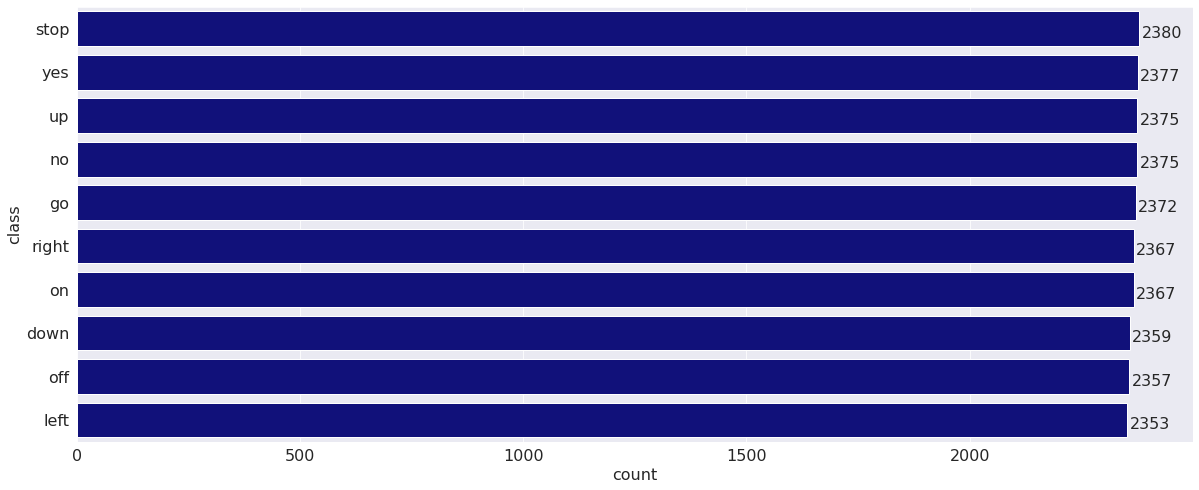

In [9]:
ax = sns.countplot(y='class',data=data,order=data['class'].value_counts().index,color='darkblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_width()), (p.get_width()+5, p.get_y()+0.6))
plt.show()

In [27]:
def show_waveplot(audio_path,label,rate):
    x , sr = librosa.load(audio_path,sr=rate)
    plt.figure(figsize=(20, 6))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: of Class: {label}")

In [24]:
samples = data.groupby('class', group_keys=False).apply(lambda x: x.sample(int(np.rint(10*len(x)/len(data))))).sample(frac=1).reset_index(drop=True)
samples

,path,class
0,/content/train/audio/left/ca48dc76_nohash_3.wav,left
1,/content/train/audio/down/cd7f8c1b_nohash_4.wav,down
2,/content/train/audio/go/179a61b7_nohash_4.wav,go
3,/content/train/audio/right/fad7a69a_nohash_0.wav,right
4,/content/train/audio/no/0362539c_nohash_1.wav,no
5,/content/train/audio/up/ad5aeec2_nohash_0.wav,up
6,/content/train/audio/yes/da1d320c_nohash_0.wav,yes
7,/content/train/audio/stop/f297e878_nohash_1.wav,stop
8,/content/train/audio/off/9a69672b_nohash_3.wav,off
9,/content/train/audio/on/8d8d9855_nohash_0.wav,on


## Waveplot Visualization
- Lets try to identify if there are any explainable observations in these amplitude values that have been chosen in so many kernels
- We will visualize the audio samples at 8000Hz and 16000Hz

### Audio Files (Sampled at 16000Hz)

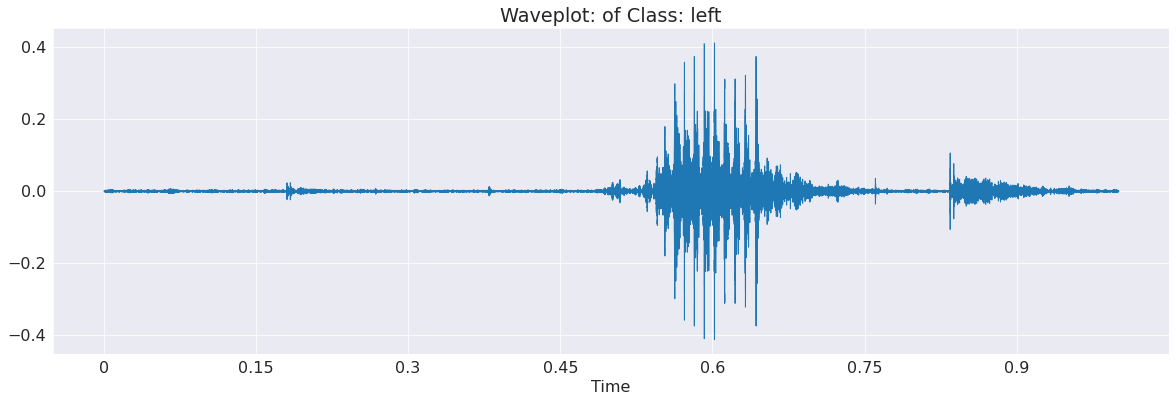

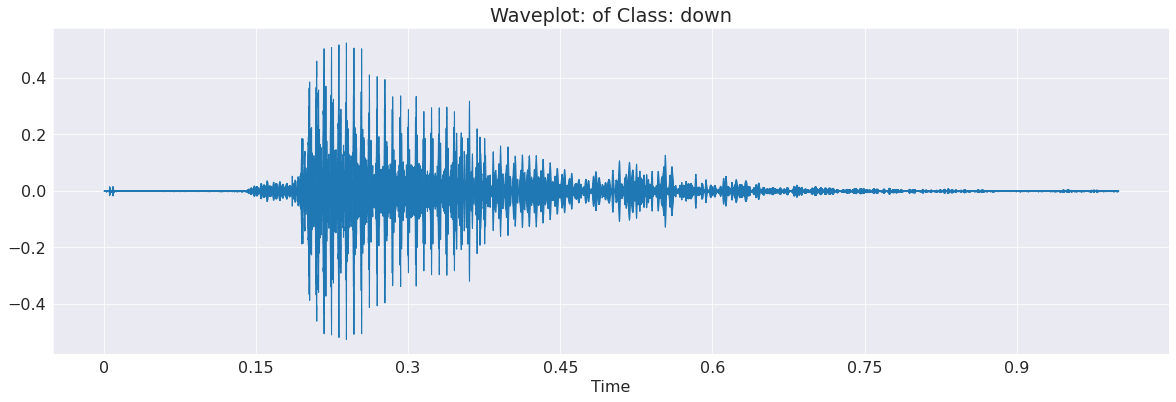

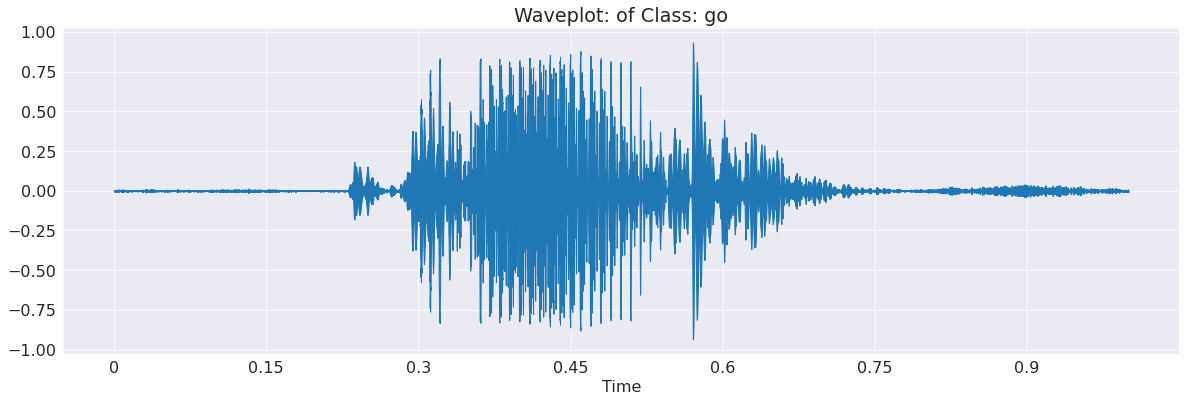

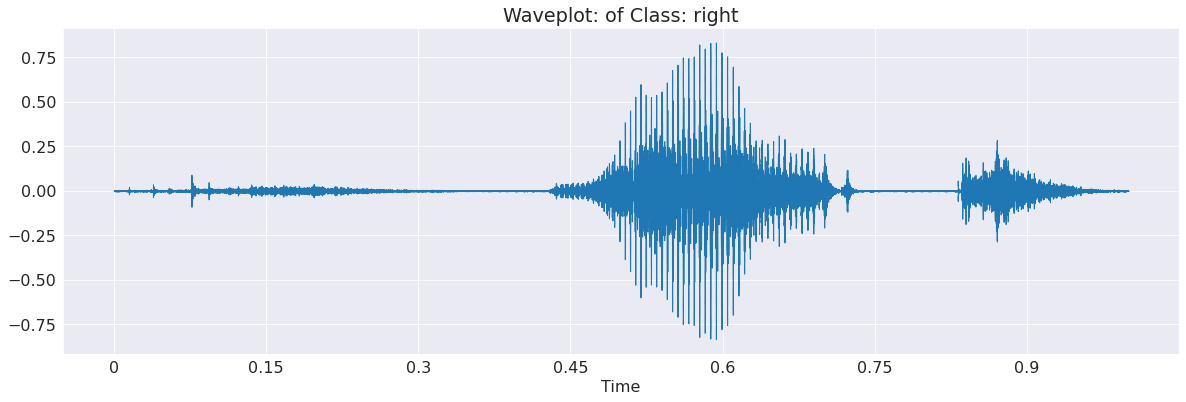

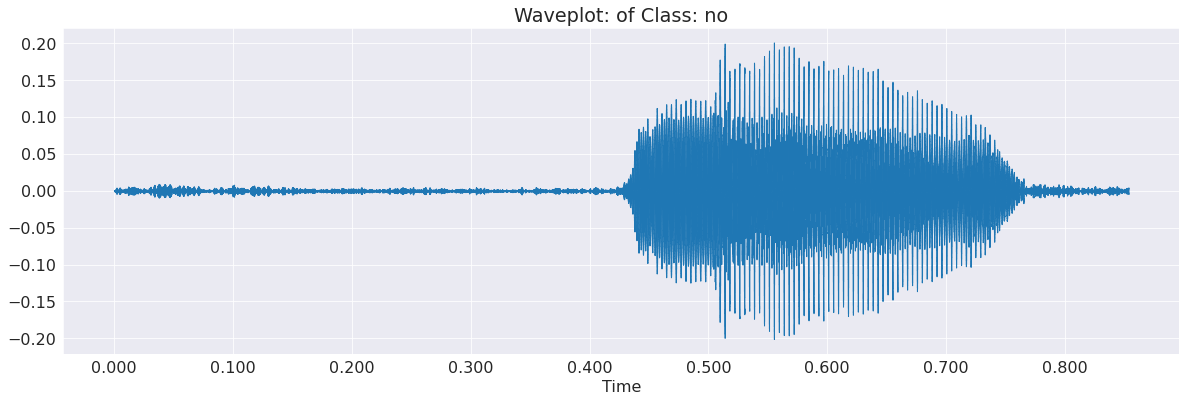

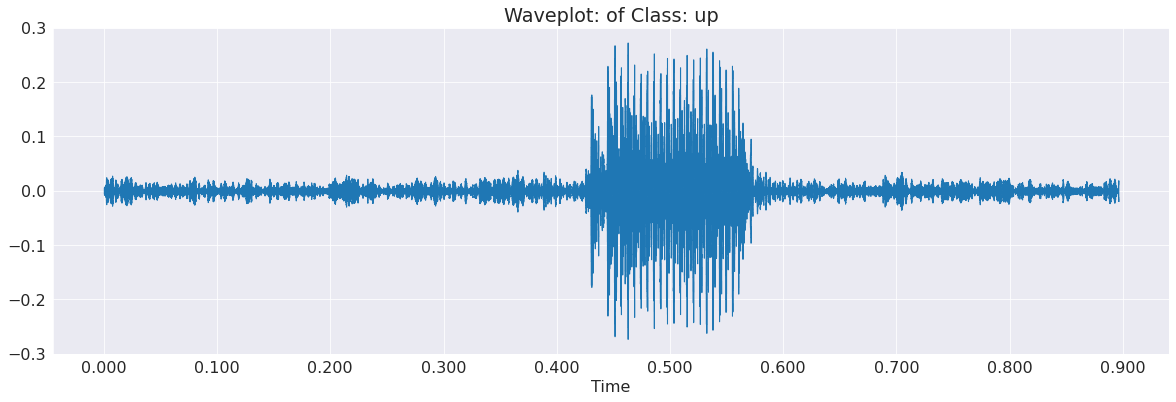

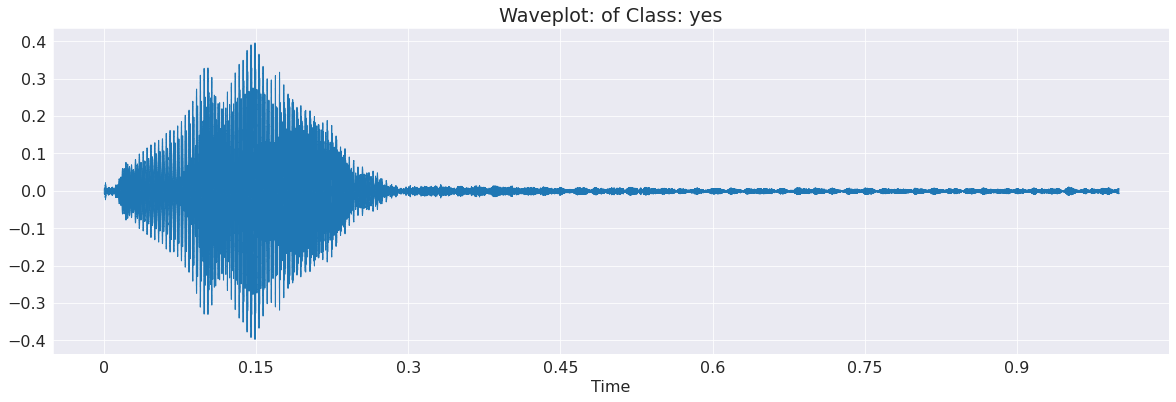

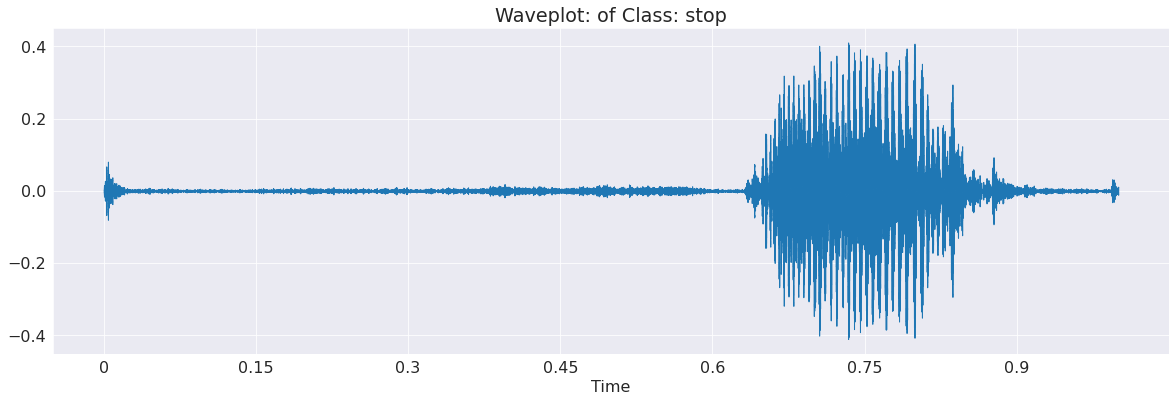

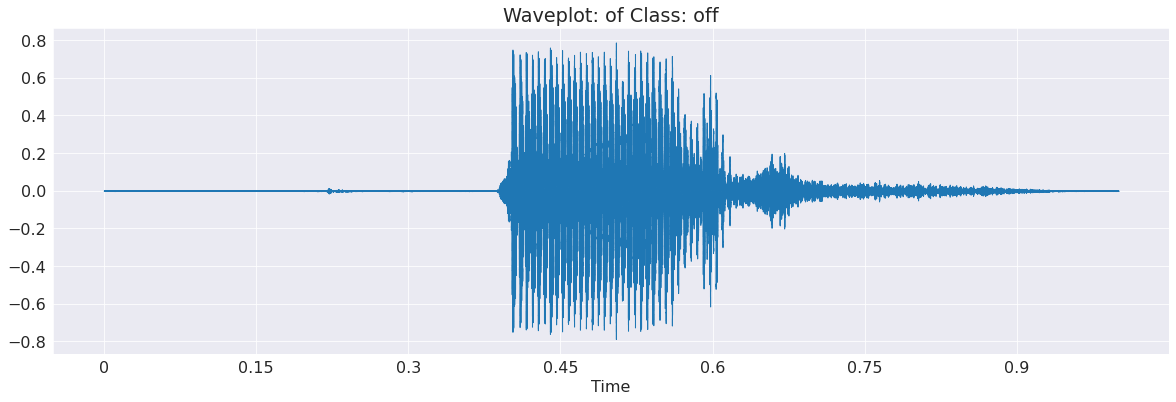

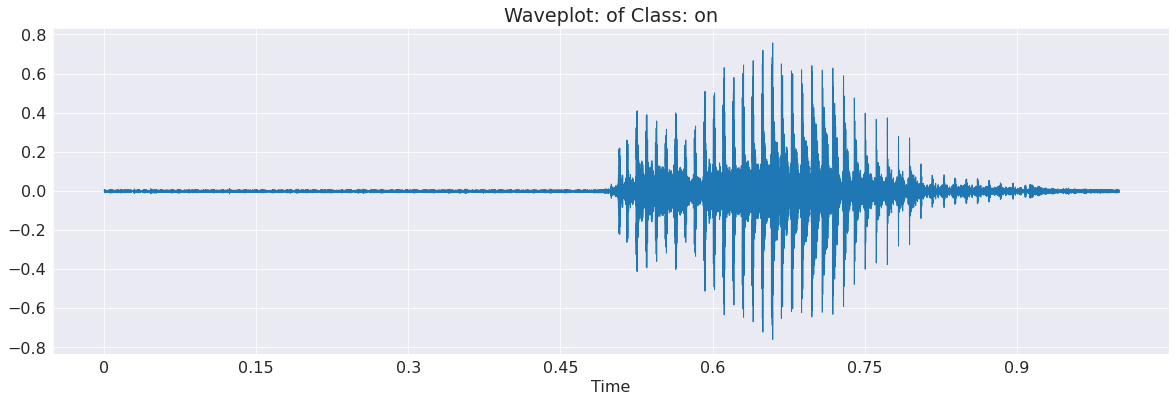

In [28]:
for index, record in samples.iterrows():
  show_waveplot(record['path'],record['class'],16000)

### Audio Files (Sampled at 8000Hz)

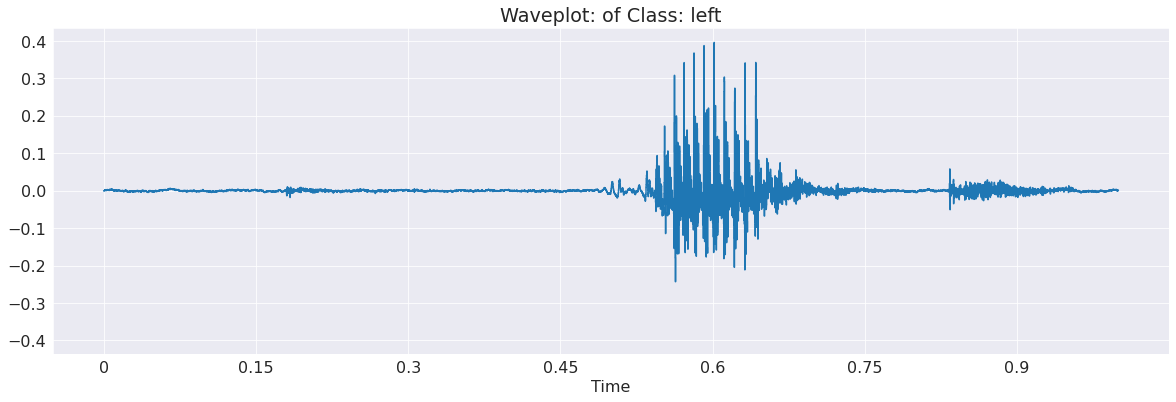

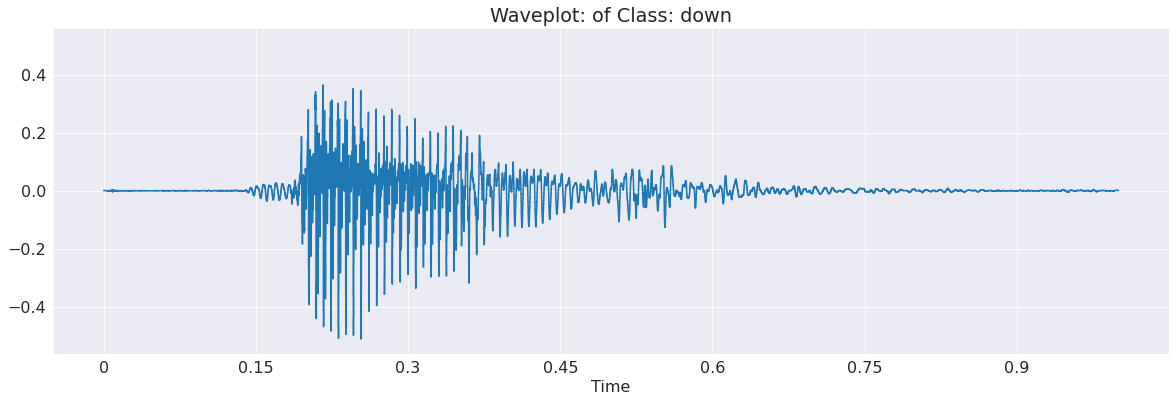

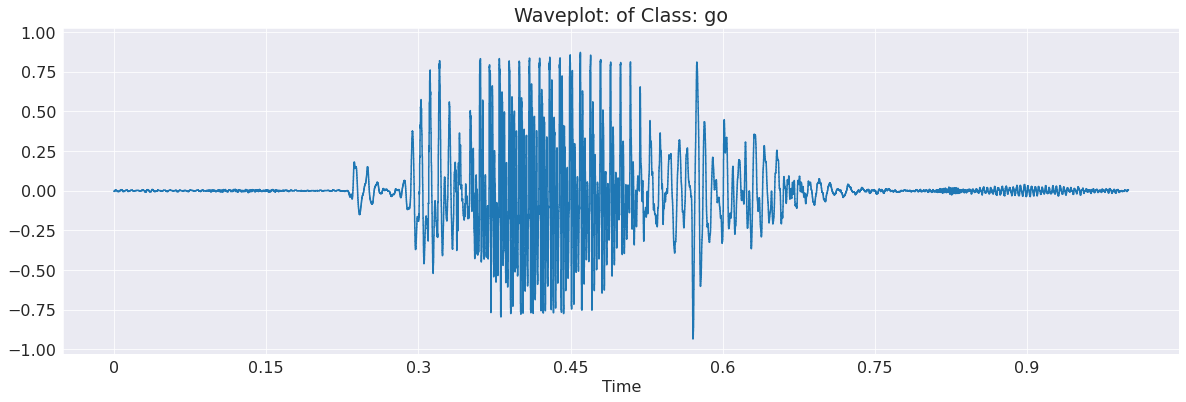

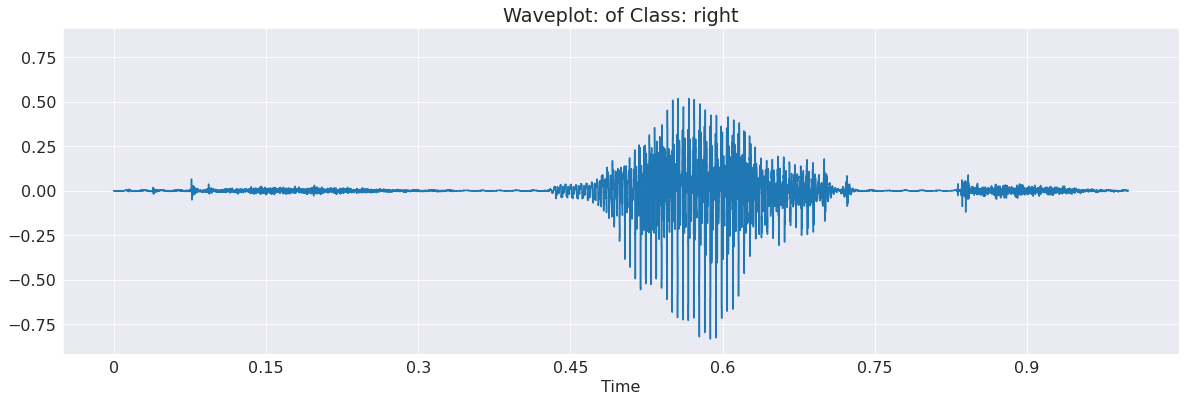

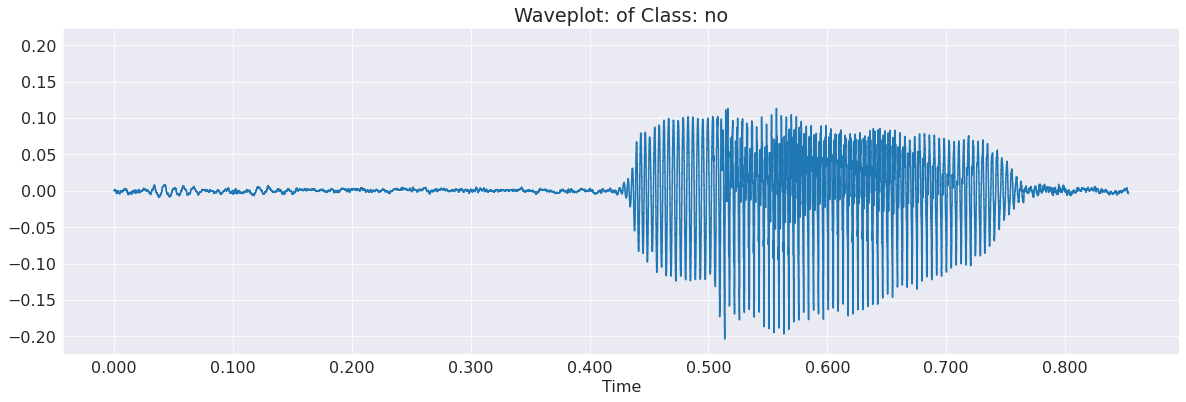

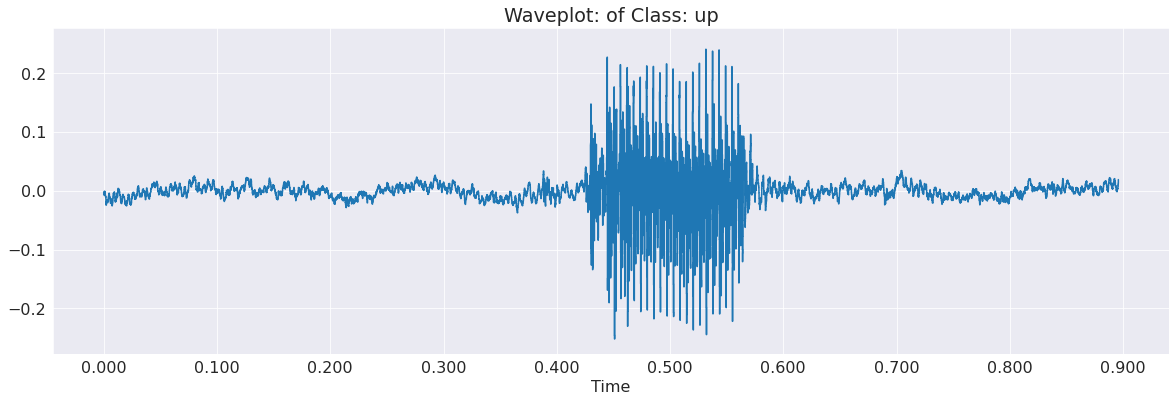

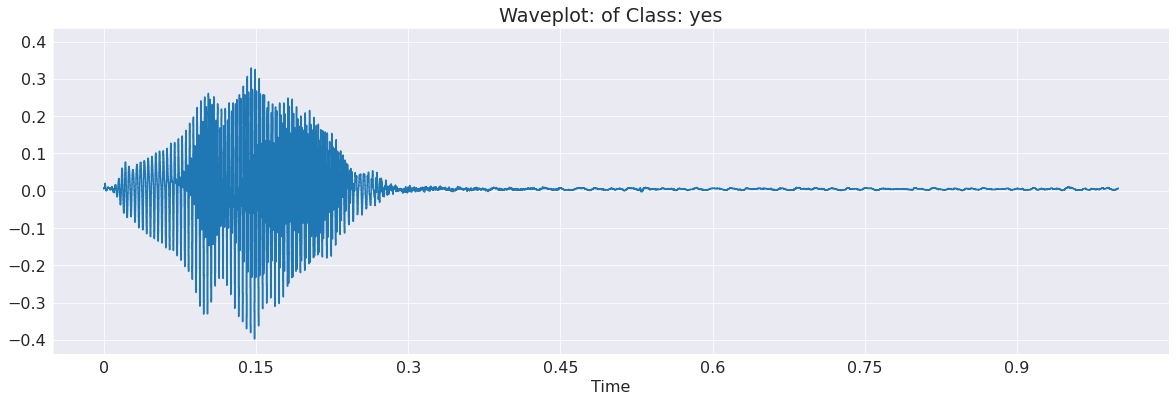

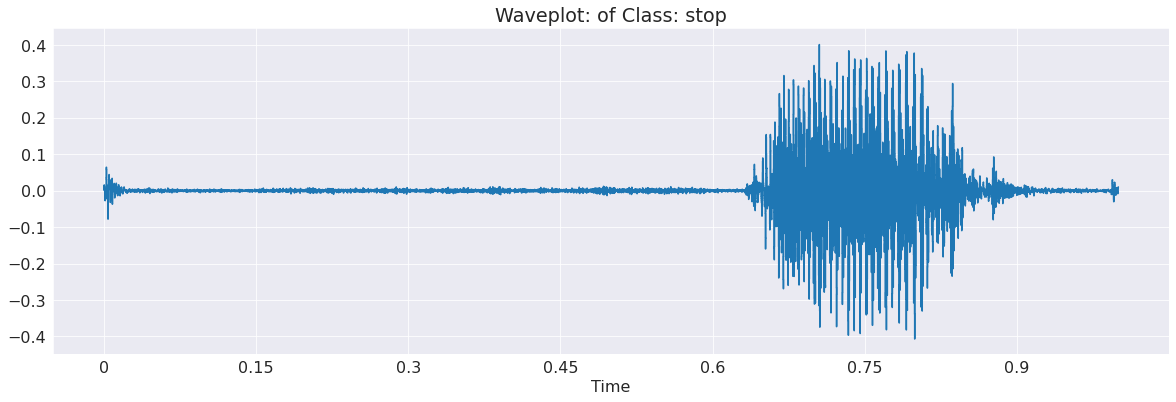

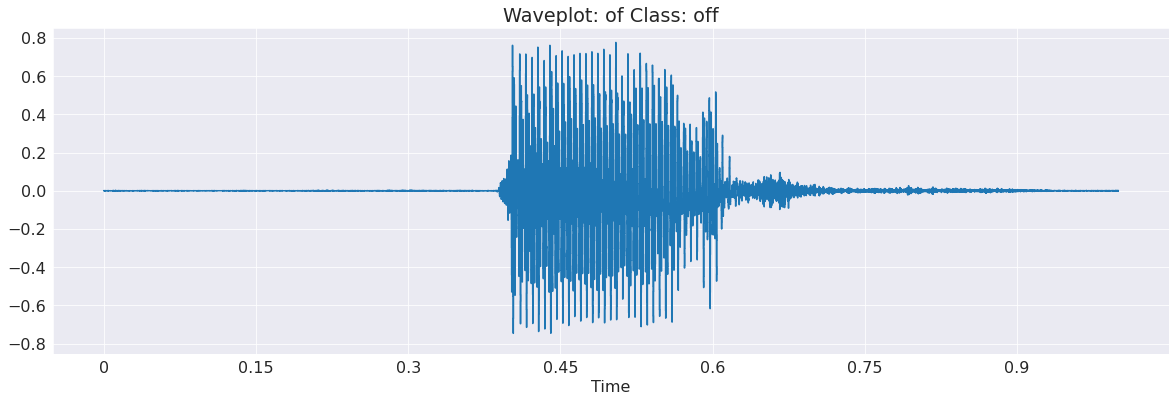

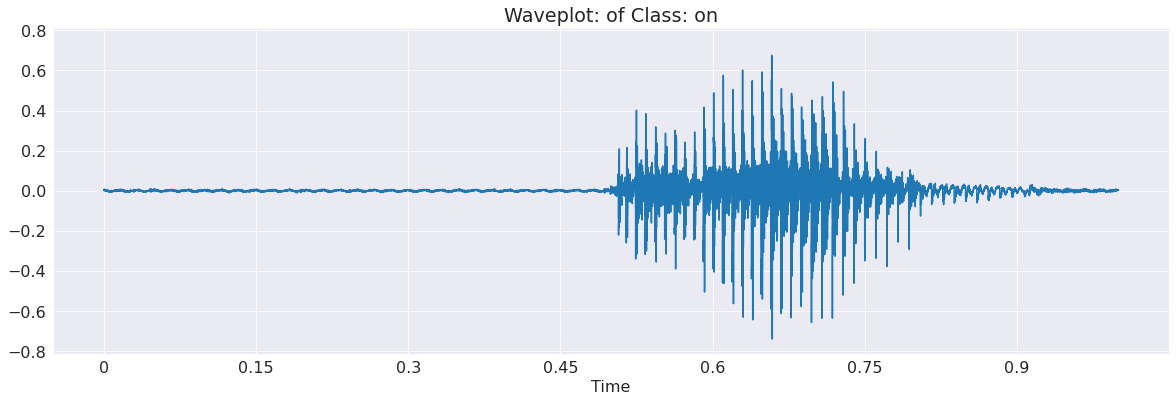

In [29]:
for index, record in samples.iterrows():
  show_waveplot(record['path'],record['class'],8000)

<p style="font-size: 16px"><strong>Inference:</strong> There is no clear distinction as as such. Lets try to identify the patterns using some of the modelling techniques.</p>

In [10]:
dataf = feature_extraction(data)
X = dataf.iloc[:,:-1].values
y = dataf.iloc[:,-1].values

100%|██████████| 23682/23682 [05:38<00:00, 69.90it/s]


In [32]:
print(f"Number of records after resampling: {len(dataf)}")
print(f"Percentage of records with atleast 8000 samples/sec: {round((len(dataf)/len(data))*100,2)}%")

Number of records after resampling: 21312
Percentage of records with atleast 8000 samples/sec: 89.99%


# Modelling
- Lets try a linear, tree based and finally a non linear neural network model
1. Logistic Regression
2. Random Forest
3. Convolutional Neural Network (1D)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [13]:
def model_train(model,X_train, X_test, y_train, y_test):
  model.fit(X_train,y_train)
  y_pred_tr = model.predict(X_train)
  y_pred = model.predict(X_test)

  print("-----------------------Training------------------------")
  print(classification_report(y_train,y_pred_tr))
  print("-----------------------Testing-------------------------")
  print(classification_report(y_test,y_pred))

## Logistic Regression

<img src="https://miro.medium.com/max/1280/1*CYAn9ACXrWX3IneHSoMVOQ.gif">

In [14]:
model = LogisticRegression()
model_train(model,X_train,X_test,y_train,y_test)

-----------------------Training------------------------
              precision    recall  f1-score   support

        down       0.71      0.69      0.70      1722
          go       0.65      0.62      0.64      1681
        left       0.64      0.66      0.65      1732
          no       0.64      0.62      0.63      1678
         off       0.65      0.63      0.64      1714
          on       0.66      0.61      0.63      1684
       right       0.69      0.65      0.67      1724
        stop       0.61      0.62      0.61      1739
          up       0.63      0.62      0.62      1650
         yes       0.58      0.70      0.63      1725

    accuracy                           0.64     17049
   macro avg       0.64      0.64      0.64     17049
weighted avg       0.64      0.64      0.64     17049

-----------------------Testing-------------------------
              precision    recall  f1-score   support

        down       0.10      0.09      0.09       430
          go       0

## Random Forest

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif">

In [15]:
model = RandomForestClassifier(max_depth=3)
model_train(model,X_train,X_test,y_train,y_test)

-----------------------Training------------------------
              precision    recall  f1-score   support

        down       0.20      0.51      0.29      1722
          go       0.18      0.19      0.18      1681
        left       0.14      0.24      0.18      1732
          no       0.33      0.00      0.00      1678
         off       0.25      0.00      0.00      1714
          on       0.28      0.01      0.02      1684
       right       0.35      0.00      0.01      1724
        stop       0.20      0.11      0.14      1739
          up       0.25      0.28      0.26      1650
         yes       0.15      0.45      0.23      1725

    accuracy                           0.18     17049
   macro avg       0.23      0.18      0.13     17049
weighted avg       0.23      0.18      0.13     17049

-----------------------Testing-------------------------
              precision    recall  f1-score   support

        down       0.18      0.46      0.26       430
          go       0

## 1D-Convolutional Neural Network

<img src="https://cezannec.github.io/assets/cnn_text/conv_1D_time.gif">

In [16]:
encoder = LabelEncoder()
X_train_cnn = X_train.reshape(-1,8000,1)
X_test_cnn = X_test.reshape(-1,8000,1)
y_train_cnn = encoder.fit_transform(y_train)
y_test_cnn = encoder.transform(y_test)

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
classes = data['class'].nunique()

In [19]:
model = Sequential([
    InputLayer(input_shape=(8000, 1)),
    Conv1D(16, 11, activation='relu', padding = "valid", strides=1),
    MaxPooling1D(3),
    Dropout(0.3),
    Conv1D(32, 9, activation='relu', padding = "valid", strides=1),
    MaxPooling1D(3),
    Dropout(0.3),
    Conv1D(64, 7, activation='relu', padding = "valid", strides=1),
    MaxPooling1D(3),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7990, 16)          192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2663, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2663, 16)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2655, 32)          4640      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 885, 32)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 885, 32)           0

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [22]:
history = model.fit(X_train_cnn, y_train_cnn, 
                    epochs=50, validation_data=(X_test_cnn,y_test_cnn), 
                    callbacks=[checkpoint,earlystopping])

Epoch 1/50
533/533 [==============================] - ETA: 0s - loss: 2.0331 - accuracy: 0.2267
Epoch 1: val_loss improved from inf to 1.53943, saving model to model.h5
533/533 [==============================] - 20s 14ms/step - loss: 2.0331 - accuracy: 0.2267 - val_loss: 1.5394 - val_accuracy: 0.4462
Epoch 2/50
531/533 [============================>.] - ETA: 0s - loss: 1.3484 - accuracy: 0.5177
Epoch 2: val_loss improved from 1.53943 to 1.08335, saving model to model.h5
533/533 [==============================] - 7s 12ms/step - loss: 1.3483 - accuracy: 0.5180 - val_loss: 1.0833 - val_accuracy: 0.6296
Epoch 3/50
530/533 [============================>.] - ETA: 0s - loss: 1.0366 - accuracy: 0.6397
Epoch 3: val_loss improved from 1.08335 to 0.85265, saving model to model.h5
533/533 [==============================] - 7s 12ms/step - loss: 1.0364 - accuracy: 0.6403 - val_loss: 0.8526 - val_accuracy: 0.7119
Epoch 4/50
530/533 [============================>.] - ETA: 0s - loss: 0.8696 - accuracy:

In [23]:
y_pred = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_test_cnn,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79       430
           1       0.71      0.74      0.73       420
           2       0.80      0.74      0.77       433
           3       0.77      0.77      0.77       420
           4       0.81      0.78      0.79       429
           5       0.90      0.86      0.88       421
           6       0.90      0.87      0.89       431
           7       0.85      0.78      0.81       435
           8       0.67      0.88      0.76       412
           9       0.80      0.84      0.82       432

    accuracy                           0.80      4263
   macro avg       0.81      0.80      0.80      4263
weighted avg       0.81      0.80      0.80      4263



<p style="font-size: 16px"><strong>Conclusion:</strong> Our Neural Network Model converges really well, and performs exceptionally well in terms of F1-score as well. We will have to further investigate why the time domain signals have worked out so well.</p>